Saving final_merge_Greece.csv to final_merge_Greece (3).csv
Using device: cuda


<ipython-input-12-a4079946b96d>:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date Time'] = pd.to_datetime(df['Date Time'], errors='coerce')


Processing batch 0 to 800
Processing batch 800 to 1600
Processing batch 1600 to 2400
Processing batch 2400 to 3200
Processing batch 3200 to 4000
Processing batch 4000 to 4800
Processing batch 4800 to 5600
Processing batch 5600 to 6400
Processing batch 6400 to 7200
Processing batch 7200 to 8000
Processing batch 8000 to 8800
Processing batch 8800 to 9600
Processing batch 9600 to 10400
Processing batch 10400 to 11200
Processing batch 11200 to 12000
Processing batch 12000 to 12800
Processing batch 12800 to 13600
Processing batch 13600 to 14400
Processing batch 14400 to 15200
Processing batch 15200 to 16000
Processing batch 16000 to 16800
Processing batch 16800 to 17600
Processing batch 17600 to 18400
Processing batch 18400 to 19200
Processing batch 19200 to 20000
Processing batch 20000 to 20800
Processing batch 20800 to 21600
Processing batch 21600 to 22400
Processing batch 22400 to 23200
Processing batch 23200 to 24000
Processing batch 24000 to 24800
Processing batch 24800 to 25600
Proces

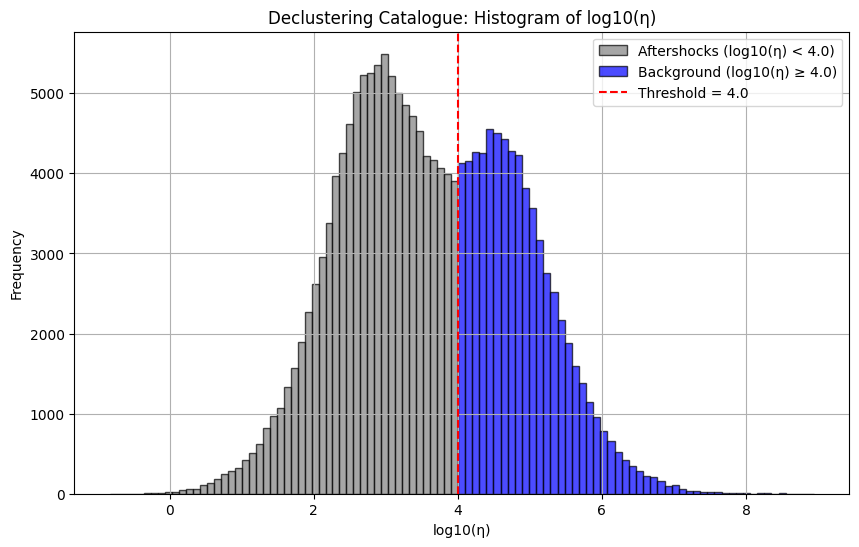

In [12]:
# ===============================
#  Cell 1: Install Requirements
# ===============================
# (Skip if already available in Colab)
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib --quiet

# ===============================
#  Cell 2: Data Processing
# ===============================
import pandas as pd
import torch
import numpy as np
from google.colab import files

# Upload dataset
uploaded = files.upload()
file_name = next(iter(uploaded))

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess data
df = pd.read_csv(file_name, delimiter='|', encoding='utf-8', on_bad_lines='skip')
df.columns = df.columns.str.strip()
df = df.rename(columns={df.columns[0]: 'Index'})

# Parse Date Time column
if 'Date Time' in df.columns:
    df['Date Time'] = pd.to_datetime(df['Date Time'], errors='coerce')
    df = df.dropna(subset=['Date Time'])
else:
    raise ValueError("'Date Time' column not found in the dataset")

# Convert to tensors
times = df['Date Time'].astype(np.int64) // 10**9
times_days = ((times - times.min()) / 86400.0).astype(np.float32)

latitudes = df['latitude'].values
longitudes = df['longitude'].values
magnitudes = df['magnitude'].values

# Move tensors to GPU/CPU
times_tensor = torch.tensor(times_days, dtype=torch.float32, device=device)
lat_tensor = torch.tensor(latitudes, dtype=torch.float32, device=device)
lon_tensor = torch.tensor(longitudes, dtype=torch.float32, device=device)
mag_tensor = torch.tensor(magnitudes, dtype=torch.float32, device=device)

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = torch.sin(dlat/2)**2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon/2)**2
    c = 2 * torch.arcsin(torch.sqrt(a))
    return R * c

# Parameters
b = 1.0
q = 0.5
batch_size = 800
n = len(df)
eta_min_list = []

# Convert to radians
lat_rad = torch.deg2rad(lat_tensor)
lon_rad = torch.deg2rad(lon_tensor)

# Batch processing
for i in range(0, n, batch_size):
    torch.cuda.empty_cache()
    print(f'Processing batch {i} to {min(i+batch_size, n)}')
    end = min(i + batch_size, n)

    batch_times = times_tensor[i:end].unsqueeze(1)
    batch_lats = lat_rad[i:end].unsqueeze(1)
    batch_lons = lon_rad[i:end].unsqueeze(1)
    batch_mags = mag_tensor[i:end].unsqueeze(1)

    dt = torch.abs(batch_times - times_tensor)
    dlat = lat_rad - batch_lats
    dlon = lon_rad - batch_lons
    a = torch.sin(dlat/2)**2 + torch.cos(batch_lats) * torch.cos(lat_rad) * torch.sin(dlon/2)**2
    c = 2 * torch.arcsin(torch.sqrt(a))
    r = 6371.0 * c

    eta = r / (10 ** (-b * batch_mags)) * (dt ** q)
    eta[:, i:] = float('inf')  # Ignore future events (j ≥ i)

    eta_min_list.append(torch.min(eta, dim=1).values.cpu().numpy())

    del dt, dlat, dlon, a, c, r, eta
    torch.cuda.empty_cache()

# Combine results
eta_min = np.concatenate(eta_min_list)
df['eta_min'] = eta_min

# Save results
df[['Date Time', 'latitude', 'longitude', 'depth', 'magnitude', 'eta_min']].to_csv('declustered_result.csv', index=False)
print(" Processing complete and results saved!")

# ===============================
#  Cell 3: Visualization
# ===============================
import matplotlib.pyplot as plt

df_declustered = pd.read_csv("declustered_result.csv")
df_declustered = df_declustered.dropna(subset=["eta_min"])
eta_values = df_declustered["eta_min"].values
eta_values = eta_values[np.isfinite(eta_values) & (eta_values > 0)]  # Remove inf and non-positive

log_eta = np.log10(eta_values[eta_values > 0])

threshold = 4.0
aftershocks = log_eta[log_eta < threshold]
background = log_eta[log_eta >= threshold]

plt.figure(figsize=(10, 6))
plt.hist(aftershocks, bins=50, color='grey',
         label='Aftershocks (log10(η) < 4.0)', alpha=0.7, edgecolor='black')
plt.hist(background, bins=50, color='blue',
         label='Background (log10(η) ≥ 4.0)', alpha=0.7, edgecolor='black')

plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("log10(η)")
plt.ylabel("Frequency")
plt.title("Declustering Catalogue: Histogram of log10(η)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import numpy as np

# Reload cleaned data
df = pd.read_csv("declustered_result.csv")
df = df.dropna(subset=["eta_min", "latitude", "longitude", "magnitude"])

# Filter aftershocks: log10(η) < 4.0 and finite η
df = df[np.isfinite(df["eta_min"]) & (df["eta_min"] > 0)]
df["log_eta"] = np.log10(df["eta_min"])
aftershocks = df[df["log_eta"] < 4.0]

# Create Folium map centered on Greece
map_center = [38.0, 23.7]  # Approximate center of Greece
m = folium.Map(location=map_center, zoom_start=6, tiles='CartoDB positron')

# Add cluster of aftershock markers
marker_cluster = MarkerCluster().add_to(m)
for _, row in aftershocks.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3 + row["magnitude"] * 0.7,  # scale by magnitude
        color="orange",
        fill=True,
        fill_color="orange",
        fill_opacity=0.7,
        popup=f"Mag: {row['magnitude']}, log10(η): {row['log_eta']:.2f}"
    ).add_to(marker_cluster)

# Save and display the map
m.save("aftershocks_map.html")
print("Map saved as aftershocks_map.html")


Map saved as aftershocks_map.html


In [14]:
from google.colab import files

# Download the HTML file to your local machine
files.download("aftershocks_map.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =========================================================================================================
# THIS WILL download an interactive map of Greece in which all the aftershocks are shown that can be viewed
# =========================================================================================================